In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from keras import backend as bk
import numpy as np

Using TensorFlow backend.


# Loading Data

In [12]:
#Data Source: https://machinelearningmastery.com/time-series-datasets-for-machine-learning/
def load_data():
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
    df = pd.read_csv(url)
    df.head(5)
    return df

# Plotting Data

In [3]:
def plot_data(df):
    %matplotlib inline
    plt.plot(df['Date'],df['Temp'])
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title('Daily minimum temperatures in Melbourne, Australia, 1981-1990')
    plt.show()

# Windowing the Input Signal

In [4]:
#Splits data into chunks of window_size with overlap
def moving_window(signal,window_size):
    features, labels = list(),list()
    i = 0
    while i < len(signal) - window_size:
        features.append(signal[i:i+window_size])
        labels.append(signal[i+window_size])
        i = i + 1
    return array(features), array(labels)

def split_data(window_size,df):
    signal = df['Temp'].values
    X, y = moving_window(signal, window_size)
    return X,y

# Train Test Split

Train Test split parameters [1]:

**test_size** : float, int or None, optional (default=None)
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. If train_size is also None, it will be set to 0.25.
e.g. for 30& test size, we choose 0.3

**train_size**: float, int, or None, (default=None)
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. If int, represents the absolute number of train samples. If None, the value is automatically set to the complement of the test size.

**random_state** : int, RandomState instance or None, optional (default=None)
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

**shuffle** : boolean, optional (default=True)
Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

**stratify** : array-like or None (default=None)
If not None, data is split in a stratified fashion, using this as the class labels.

In [5]:
def train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 42)
    return X_train, X_test, y_train, y_test

# Build LSTM Model

LSTM parameters [2]:   
**units**: Positive integer, dimensionality of the output space.  
**activation**: Activation function to use (see activations). Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).  
recurrent_activation: Activation function to use for the recurrent step (see activations). Default: hard sigmoid (hard_sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
use_bias: Boolean, whether the layer uses a bias vector.  
**kernel_initializer**: Initializer for the kernel weights matrix, used for the linear transformation of the inputs. (see initializers).  
**recurrent_initializer**: Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. (see initializers).  
**bias_initializer**: Initializer for the bias vector (see initializers).  
unit_forget_bias: Boolean. If True, add 1 to the bias of the forget gate at initialization. Setting it to true will also force bias_initializer="zeros". This is recommended in Jozefowicz et al. (2015).  
**kernel_regularizer**: Regularizer function applied to the kernel weights matrix (see regularizer).    
**recurrent_regularizer**: Regularizer function applied to the recurrent_kernel weights matrix (see regularizer).  
**bias_regularizer**: Regularizer function applied to the bias vector (see regularizer).  
**activity_regularizer**: Regularizer function applied to the output of the layer (its "activation"). (see regularizer).  
**kernel_constraint**: Constraint function applied to the kernel weights matrix (see constraints).  
**recurrent_constraint**: Constraint function applied to the recurrent_kernel weights matrix (see constraints).  
**bias_constraint**: Constraint function applied to the bias vector (see constraints).  
**dropout**: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.  
**recurrent_dropout**: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.    
**implementation**: Implementation mode, either 1 or 2. Mode 1 will structure its operations as a larger number of smaller dot products and additions, whereas mode 2 will batch them into fewer, larger operations. These modes will have different performance profiles on different hardware and for different applications.  
**return_sequences**: Boolean. Whether to return the last output in the output sequence, or the full sequence.  
**return_state**: Boolean. Whether to return the last state in addition to the output. The returned elements of the states list are the hidden state and the cell state, respectively.  
**go_backwards**: Boolean (default False). If True, process the input sequence backwards and return the reversed sequence.  
**stateful**: Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.  
**unroll**: Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.  

In [6]:
def build_model(state_variable_length, activation, optimizer,window_size,loss):
    n_features = 1 #univariate time series

    #model parameters
    #state_variable_length = 50 #try out 10,50,100,150
    #activation = 'softmax'#try out softmax, relu, sigmoid
    #optimizer = 'adam' #try out SGD, RMSprop, Adagrad, Adamax

    #building a model
    bk.clear_session()
    model = Sequential() 
    model.add(LSTM(state_variable_length, activation=activation, input_shape=(window_size, n_features)))
    model.add(Dense(1)) #fully connected outer layer
    model.compile(optimizer='adam', loss=loss)
    return model,n_features

In [7]:
def train_model(X_train, n_features,epochs,batch_size,model):
    #Reshaping the stream of input data going into the model
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

    #training parameters
    #epochs = 100 #try 10,100,500, 1000
    #batch_size = 32 #try 32,64,128

    # fit model
    model.fit(X_train, y_train, epochs=epochs,batch_size=batch_size,verbose=0)
    return model

# Predicting Test samples

In [8]:
def test_model(X_test,y_test,model):
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    y_pred = model.predict(X_test, verbose=0)

    testScore = math.sqrt(mean_squared_error(y_test,y_pred))
    #print('Test Score: %.2f RMSE' % (testScore))
    return testScore

# Running the Code with different Parameters

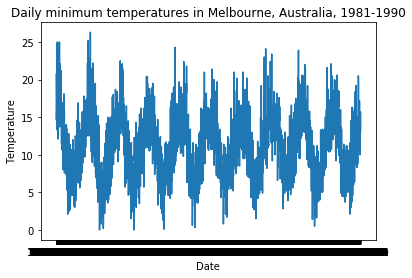

In [9]:
df = load_data()
plot_data(df)

window_size = 5 #try 3,5,7
X,y = split_data(window_size,df)

X_train, X_test, y_train, y_test = train_test(X,y)


In [10]:
state_variable_length = 10 #try 10,50,100
activation = ['softmax','relu', 'sigmoid', 'tanh', 'softsign']
optimizer = 'adam' #try out SGD, RMSprop, adam ,Adagrad, Adamax
loss = 'mean_squared_error' #try mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_logarithmic_error
testScores = list()
for act in activation:
    model,n_features = build_model(state_variable_length, act, optimizer,window_size,loss)

    epochs = 100 #try 10,100,500, 1000
    batch_size = 32 #try 32,64,128
    model = train_model(X_train, n_features,epochs,batch_size,model)
    testScore = test_model(X_test,y_test,model)
    testScores.append(testScore)
    print('Test Score with activation ',act,': %.2f RMSE' % (testScore))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Test Score with activation  softmax : 2.99 RMSE
Test Score with activation  relu : 2.31 RMSE
Test Score with activation  sigmoid : 2.33 RMSE
Test Score with activation  tanh : 2.31 RMSE
Test Score with activation  softsign : 2.34 RMSE


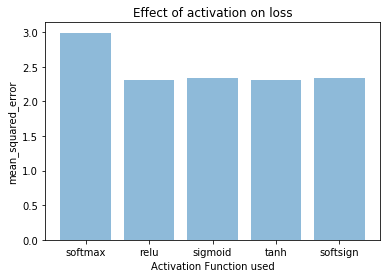

In [11]:
y_pos = np.arange(len(activation))
plt.bar(y_pos, testScores, align='center', alpha=0.5)
plt.xticks(y_pos, activation)
plt.ylabel(loss)
plt.xlabel('Activation Function used')
plt.title('Effect of activation on loss')
plt.show()

# References

[1] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
[2] https://keras.io/layers/recurrent/  
[3] Data Source: https://machinelearningmastery.com/time-series-datasets-for-machine-learning/  